In [413]:
import os, sys, json
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import io
from keras.preprocessing import sequence
from keras.layers import Input,concatenate, merge, Dense, Dropout, Activation, RepeatVector, Permute, Reshape, RepeatVector, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D, AveragePooling1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import  GRU
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss, classification_report,accuracy_score,f1_score
%matplotlib inline

In [414]:
class Dictionary(object):
    # to store the vocabulary
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = ['<pad>', '<unk>']
        self.tag2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2tag = ['<pad>', '<unk>'] 
        self.word_vocab_size = 2 
        self.tag_vocab_size  = 2

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
            self.word_vocab_size+=1
        return self.word2idx[word]
    
    def add_tag(self, tag):
        if tag not in self.tag2idx:
            self.idx2tag.append(tag)
            self.tag2idx[tag] = len(self.idx2tag) - 1
            self.tag_vocab_size+=1
        return self.tag2idx[tag]   

    def __len__(self):
        return len(self.idx2word)


class SlotDataset(object):
    
    def __init__(self):
        self.utterances = []
        self.tags =[]
        self.padded_utterances = []
        self.padded_tags =[]
        self.one_hot_tags =[]
        
    def add_utterance(self, utt):
        self.utterances.append(utt)
        
    def add_slots(self, slots):
        self.tags.append(slots)
        
    def pad_utts(self,time_length=100):
        self.padded_utterances = sequence.pad_sequences(self.utterances, maxlen=time_length, dtype='int32', padding='pre')
        return self.padded_utterances
    
    def pad_tags(self,time_length=100):
        self.padded_tags = sequence.pad_sequences(self.tags, maxlen=time_length, dtype='int32', padding='pre')
        return self.padded_tags
    
    def get_one_hot_tags(self,tag_vocab_size=100):
        self.one_hot_tags =[]
        for i,sentence  in  enumerate(self.padded_tags):
            temp_sent = self.convert_to_one_hot(sentence,tag_vocab_size)
            self.one_hot_tags.append(temp_sent)
        self.one_hot_tags = np.array(self.one_hot_tags)
        return self.one_hot_tags
    
    def convert_to_one_hot(self,Y, C):
        Y = np.eye(C)[Y.reshape(-1)]
        return Y
    
    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    
    def __init__(self, data_dir='data',embeddings_file="glove.6B.50d.txt", train_file="atis-2.train.w-intent.iob", valid_file="atis-2.dev.w-intent.iob" ,test_file="atis.test.w-intent.iob",):
        self.train = SlotDataset()
        self.valid = SlotDataset()
        self.test = SlotDataset()
        
        self.dictionary = Dictionary()
        #self.embeddings = GolveEmbbedings(os.path.join(data_dir, embeddings_file))
        self.load_train(os.path.join(data_dir, train_file))
        self.load_valid(os.path.join(data_dir, valid_file))
        self.load_test(os.path.join(data_dir, test_file))
        
    def load_train(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags=line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words)):
                id_word = self.dictionary.add_word(words[i])
                id_tag  = self.dictionary.add_tag(tags[i])
                temp_utt.append(id_word)
                temp_tags.append(id_tag)
            self.train.add_utterance(np.array(temp_utt))
            self.train.add_slots(np.array(temp_tags))
    
    def load_valid(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words)):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[i] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[i]])
            self.valid.add_utterance(np.array(temp_utt))
            self.valid.add_slots(np.array(temp_tags))
            
    def load_test(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words)):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[i] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[i]])
            self.test.add_utterance(np.array(temp_utt))
            self.test.add_slots(np.array(temp_tags))

In [415]:
class GolveEmbbedings(object): 
    
    def __init__(self,file_name):
        self.words,self.embeddings = self.loadEmbeddings(file_name)
        
    def loadEmbeddings(self, path):
        with open(path, 'r') as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word = line[0]
                words.add(curr_word)
                word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        return words, word_to_vec_map

In [416]:
corpus = Corpus()

In [417]:
max_len  = max([ len(x) for x in  corpus.train.utterances])
vocab_size = len(corpus.dictionary.word2idx)
tag_vocab_size = len(corpus.dictionary.tag2idx)
embedding_size = 50
corpus.train.pad_utts(time_length=max_len)
corpus.train.pad_tags(time_length=max_len)
corpus.valid.pad_utts(time_length=max_len)
corpus.valid.pad_tags(time_length=max_len)
corpus.test.pad_utts(time_length=max_len)
corpus.test.pad_tags(time_length=max_len)[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  4, 21,  2,  2,  2,  2,  2, 15, 22,  7],
      dtype=int32)

In [418]:
X_train = corpus.train.padded_utterances
X_valid = corpus.valid.padded_utterances
X_test = corpus.test.padded_utterances

In [419]:
print(corpus.train.utterances[0])
print(corpus.train.tags[0])

[ 2  3  4  5  6  7  8  5  9 10 11 12]
[2 2 2 2 2 2 3 2 4 5 6 7]


In [420]:
print("Train shape " + str(X_train.shape))
print("Dev shape " + str(X_valid.shape))
print("Test shape " + str(X_test.shape))


Train shape (4478, 48)
Dev shape (500, 48)
Test shape (893, 48)


In [421]:
Y_train = corpus.train.get_one_hot_tags(tag_vocab_size)
Y_valid = corpus.valid.get_one_hot_tags(tag_vocab_size)
Y_test = corpus.test.get_one_hot_tags(tag_vocab_size)

In [422]:
print("Train label shape " + str(Y_train.shape))
print("Dev label shape " + str(Y_valid.shape))
print("Test label shape " + str(Y_test.shape))

Train label shape (4478, 48, 143)
Dev label shape (500, 48, 143)
Test label shape (893, 48, 143)


/home/startup/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/startup/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


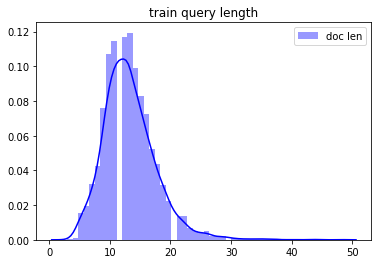

In [252]:
dist_train =  pd.Series([x.shape[0] for x in corpus.train.utterances])
sns.distplot(dist_train, hist=True, kde=True, color='b', label='doc len')
plt.title('train query length'); plt.legend()
plt.show()

/home/startup/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/startup/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


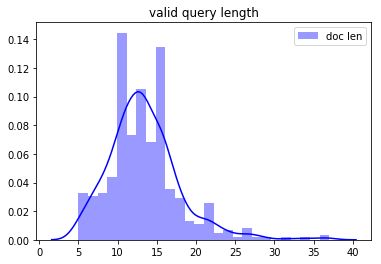

In [253]:
dist_valid =  pd.Series([x.shape[0] for x in corpus.valid.utterances])
sns.distplot(dist_valid, hist=True, kde=True, color='b', label='doc len')
plt.title('valid query length'); plt.legend()
plt.show()

/home/startup/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/startup/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


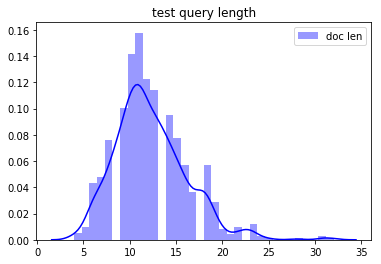

In [254]:
dist_test =  pd.Series([x.shape[0] for x in corpus.test.utterances])
sns.distplot(dist_test, hist=True, kde=True, color='b', label='doc len')
plt.title('test query length'); plt.legend()
plt.show()

/home/startup/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


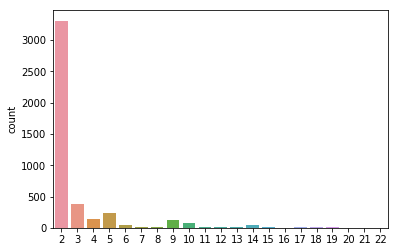

In [411]:
df = pd.Series([x[0]for x in corpus3.train.tags])
sns.countplot(df.values)

In [423]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [424]:
class SlotFilingModel(object):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True):
        self.model = self.model(vocab_size,tag_vocab_size,max_length_sequence,embedding_size)
        self.model_path = model_path+'.h5'
        self.batch_size =batch_size
        self.nb_epochs = nb_epochs
        self.loss = 'categorical_crossentropy'
        self.optimizer = 'adam'
        self.early_stop = early_stop
        self.idx2tags = idx2tags
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy',f1,recall,precision])
        self.model.summary()
    
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        pass
    
    def fit(self,X_train,Y_train,X_valid,Y_valid):
        early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=4,verbose=1)
        callbacks_list = [early_stopping]
        if self.early_stop :
            self.model.fit(X_train,Y_train,batch_size=self.batch_size,epochs=self.nb_epochs,callbacks=callbacks_list,validation_data=[X_valid,Y_valid],shuffle=True)
        else:
            self.model.fit(X_train,Y_train,batch_size=self.batch_size,epochs=self.nb_epochs,validation_data=[X_valid,Y_valid],shuffle=True)
        self.save(self.model_path)
        
    def evaluate(self,X,Y):
        if os.path.exists(self.model_path):
            self.load(self.model_path)
        loss, acc,f1,recall,precision = self.model.evaluate(X, Y)
        print("accuracy = {} - f1-score = {} - recall = {} - precision = {}".format(acc,f1,recall,precision))        
        
    def predict(self,X):
        if os.path.exists(self.model_path):
            self.load(self.model_path)
        res = []
        preds = self.model.predict(X) 
        for exemple in preds :
            res_temp = []
            for timestamp in exemple :
                res_temp.append(self.idx2tags[np.argmax(timestamp)])
            res.append(res_temp)    
        return res
    
    def predict_no_padding(self,X,Y):
        if os.path.exists(self.model_path):
            self.load(self.model_path)
        preds = self.model.predict(X)
        res_total = []
        pre_total = []
        res_intent = []
        pre_intent = []
        res_slot = []
        pre_slot = []
        cpt = 0
        p=0
        for i,y in enumerate(Y):
            for j,a in enumerate(y):
                t = np.argmax(a)
                if t != 0:
                    if np.argmax(Y[i][j]) == 2 :
                        p+=1
                    if X[i][j] == 12:
                        res_intent.append(t)
                        pre_intent.append(np.argmax(preds[i][j]))
                    else :
                        res_slot.append(t)
                        pre_slot.append(np.argmax(preds[i][j]))
                    res_total.append(t)
                    pre_total.append(np.argmax(preds[i][j]))
                else:
                    cpt+=1
        print("Pourcentage de la classe <pad> :",cpt/(len(X[0])*len(X)))
        print("Pourcentage de la classe O :",p/(len(Y[0])*len(Y)))
        print("Accuracy totale :",accuracy_score(res_total,pre_total))
        print("F1 score totale :",f1_score(res_total,pre_total,average='weighted'))
        print("Accuracy intent :",accuracy_score(res_intent,pre_intent))
        print("F1 score intent :",f1_score(res_intent,pre_intent,average='weighted'))
        print("Accuracy slot :",accuracy_score(res_slot,pre_slot))
        print("F1 score slot :",f1_score(res_slot,pre_slot,average='weighted'))
        print('--------------------------------------------------')
    
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


# Baselines

## 2 Layers GRU :

In [203]:
class TwoGruModel(SlotFilingModel):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True):
        super().__init__(vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True)
        
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        
        X_input = Input(shape=(max_length_sequence,), dtype='int32')
        X = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length_sequence, mask_zero = True)(X_input)
        
        X = GRU(units = 150, return_sequences = True)(X)    # GRU (use 150 units and return the sequences)
        X = Dropout(0.8)(X)                                 # dropout (use 0.8)
        X = BatchNormalization()(X)                         # Batch normalization

        X = GRU(units = 150, return_sequences = True)(X)    # GRU (use 150 units and return the sequences)
        X = Dropout(0.8)(X)                                 # dropout (use 0.8)
        X = BatchNormalization()(X)                         # Batch normalization
        X = Dropout(0.8)(X)                                 # dropout (use 0.8)

        X = TimeDistributed(Dense(tag_vocab_size, activation = "softmax"))(X) # time distributed  (sigmoid)
        model = Model(inputs = X_input, outputs = X)
        return model 

    

In [260]:
model_gru = TwoGruModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus.dictionary.idx2tag,"two_gru_model")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 48)                0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 48, 50)            43550     
_________________________________________________________________
gru_67 (GRU)                 (None, 48, 150)           90450     
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 150)           0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 150)           600       
_________________________________________________________________
gru_68 (GRU)                 (None, 48, 150)           135450    
_________________________________________________________________
dropout_14 (Dropout)         (None, 48, 150)           0         
__________

In [261]:
model_gru.fit(X_train,Y_train,X_valid,Y_valid)

Train on 4478 samples, validate on 500 samples
Epoch 1/10
4478/4478 [==============================] - 68s 15ms/step - loss: 4.0728 - acc: 0.3949 - f1: 0.1536 - recall: 0.0878 - precision: 0.6266 - val_loss: 1.2732 - val_acc: 0.7726 - val_f1: 0.3233 - val_recall: 0.1960 - val_precision: 0.9261
Epoch 2/10
4478/4478 [==============================] - 56s 12ms/step - loss: 1.6185 - acc: 0.6981 - f1: 0.2807 - recall: 0.1656 - precision: 0.9234 - val_loss: 0.9835 - val_acc: 0.7908 - val_f1: 0.3541 - val_recall: 0.2174 - val_precision: 0.9565
Epoch 3/10
4478/4478 [==============================] - 58s 13ms/step - loss: 1.2783 - acc: 0.7459 - f1: 0.3067 - recall: 0.1835 - precision: 0.9343 - val_loss: 0.8706 - val_acc: 0.8258 - val_f1: 0.3551 - val_recall: 0.2180 - val_precision: 0.9592
Epoch 4/10
4478/4478 [==============================] - 53s 12ms/step - loss: 1.1182 - acc: 0.7670 - f1: 0.3200 - recall: 0.1928 - precision: 0.9419 - val_loss: 0.7939 - val_acc: 0.8396 - val_f1: 0.3641 - val_

In [262]:
model_gru.predict_no_padding(X_test,Y_test)

Pourcentage de la classe <pad> : 0.7445408734602463
Accuracy totale : 0.8864840182648401
F1 score totale : 0.13399515354996552
Accuracy intent : 0.7077267637178052
F1 score intent : 0.04875602700096432
Accuracy slot : 0.9023565675648801
F1 score slot : 0.1463895821233685


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [263]:
model_gru.evaluate(X_test,Y_test)

893/893 [==============================] - 4s 4ms/step
accuracy = 0.8858357752691057 - f1-score = 0.34744741661684775 - recall = 0.21327921955075535 - precision = 0.9514032573609176


In [264]:
idx_test = 500
ex = [corpus.dictionary.idx2tag[x] for x in corpus.test.padded_tags[idx_test] if corpus.dictionary.idx2tag[x] !='<pad>']
ind = len(ex)
pred = [x for x in model_gru.predict(X_test)[idx_test]]
print("Exemple source:", ' '.join(ex))
print("Exemple prédit:",' '.join(pred[48-ind:]))

Exemple source: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight_no
Exemple prédit: O O O O O O O O O O B-depart_date.day_name B-airline_name B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight


## Bidirectional LSTM

In [425]:
class BidirectionalLSTMModel(SlotFilingModel):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True):
        super().__init__(vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True)
        
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        X_input = Input(shape=(max_length_sequence,), dtype='int32')
        X = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length_sequence, mask_zero = True)(X_input)
        A = LSTM(100, return_sequences=True, init='glorot_uniform', activation='relu')(X)
        B = LSTM(100, return_sequences=True, init='glorot_uniform', activation='relu', go_backwards=True)(X)
        res = concatenate([A, B])
        output = TimeDistributed(Dense(tag_vocab_size, activation = "softmax"))(res) # time distributed  (sigmoid)
        model = Model(inputs = X_input, outputs = output)
        return model

In [426]:
model_blstm = BidirectionalLSTMModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus.dictionary.idx2tag,"blstm_model")

/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="relu", kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="relu", go_backwards=True, kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 48, 50)       43550       input_60[0][0]                   
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 48, 100)      60400       embedding_60[0][0]               
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 48, 100)      60400       embedding_60[0][0]               
__________________________________________________________________________________________________
concatenat

In [427]:
model_blstm.fit(X_train,Y_train,X_valid,Y_valid)

Train on 4478 samples, validate on 500 samples
Epoch 1/10
4478/4478 [==============================] - 46s 10ms/step - loss: 2.5422 - acc: 0.6109 - f1: 0.1248 - recall: 0.0871 - precision: 0.3108 - val_loss: 1.5932 - val_acc: 0.6518 - val_f1: 0.1858 - val_recall: 0.1469 - val_precision: 0.2537
Epoch 2/10
4478/4478 [==============================] - 37s 8ms/step - loss: 1.0190 - acc: 0.7787 - f1: 0.2614 - recall: 0.1990 - precision: 0.3914 - val_loss: 0.7704 - val_acc: 0.8273 - val_f1: 0.3305 - val_recall: 0.2158 - val_precision: 0.7108
Epoch 3/10
4478/4478 [==============================] - 46s 10ms/step - loss: 0.5632 - acc: 0.8669 - f1: 0.3612 - recall: 0.2266 - precision: 0.9023 - val_loss: 0.5197 - val_acc: 0.8758 - val_f1: 0.3720 - val_recall: 0.2310 - val_precision: 0.9578
Epoch 4/10
4478/4478 [==============================] - 35s 8ms/step - loss: 0.3729 - acc: 0.9132 - f1: 0.3852 - recall: 0.2406 - precision: 0.9692 - val_loss: 0.3780 - val_acc: 0.9171 - val_f1: 0.3896 - val_re

In [428]:
model_blstm.predict_no_padding(X_test,Y_test)

Pourcentage de la classe <pad> : 0.7445408734602463
Pourcentage de la classe O : 0.14916946621873833
Accuracy totale : 0.9541552511415525
F1 score totale : 0.9470752686674803
Accuracy intent : 0.8499440089585666
F1 score intent : 0.8144014806131975
Accuracy slot : 0.9634085711444765
F1 score slot : 0.9588558884082055
--------------------------------------------------


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [429]:
model_blstm.evaluate(X_test,Y_test)

893/893 [==============================] - 2s 3ms/step
accuracy = 0.9541042330283734 - f1-score = 0.38363249241171066 - recall = 0.24106476742102612 - precision = 0.9556385688525432


In [431]:
idx_test = 500
ex = [corpus.dictionary.idx2tag[x] for x in corpus.test.padded_tags[idx_test] if corpus.dictionary.idx2tag[x] !='<pad>']
ind = len(ex)
pred = [x for x in model_blstm.predict(X_test)[idx_test]]
print("Exemple source:", ' '.join(ex))
print("Exemple prédit:",' '.join(pred[48-ind:]))

48
Exemple source: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight_no
Exemple prédit: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight


## Sequence to Sequence Model

In [313]:
class SeqToSeqModel(SlotFilingModel):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=20, early_stop=True):
        super().__init__(vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=25, early_stop=True)
        
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        X_input = Input(shape=(max_length_sequence,), dtype='int32')
        X = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length_sequence, mask_zero = True)(X_input)
        forward = GRU(150,  return_sequences=False, init='glorot_uniform', activation='relu')(X)
        backward = GRU(150, return_sequences=False, init='glorot_uniform', activation='relu', go_backwards=True)(X)                                 # dropout (use 0.8)
        forward_target = GRU(150, return_sequences=True, init='glorot_uniform', activation='relu')(X)
        backward_target = GRU(150, return_sequences=True, init='glorot_uniform', activation='relu', go_backwards=True)(X)
        encoder = concatenate([forward, backward])
        target = concatenate([forward_target, backward_target])
        encoder = RepeatVector(max_length_sequence)(encoder)
        tagger = concatenate([encoder, target])
        output = TimeDistributed(Dense(tag_vocab_size, activation = "softmax"))(tagger) # time distributed  (softmax)
        model = Model(inputs = X_input, outputs = output)
        return model

In [314]:
model_seq2seq = SeqToSeqModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus.dictionary.idx2tag,"seq2seq_model")

/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", go_backwards=True, kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=True, activation="relu", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=True, 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 47)           0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 47, 50)       43500       input_52[0][0]                   
__________________________________________________________________________________________________
gru_86 (GRU)                    (None, 150)          90450       embedding_52[0][0]               
__________________________________________________________________________________________________
gru_87 (GRU)                    (None, 150)          90450       embedding_52[0][0]               
__________________________________________________________________________________________________
concatenat

In [255]:
model_seq2seq.fit(X_train,Y_train,X_valid,Y_valid)

Train on 4478 samples, validate on 500 samples
Epoch 1/25
4478/4478 [==============================] - 61s 14ms/step - loss: 0.1712 - acc: 0.9587 - f1: 0.4074 - recall: 0.2606 - precision: 0.9368 - val_loss: 0.1965 - val_acc: 0.9575 - val_f1: 0.4031 - val_recall: 0.2625 - val_precision: 0.8761
Epoch 2/25
4478/4478 [==============================] - 60s 13ms/step - loss: 0.1235 - acc: 0.9695 - f1: 0.4008 - recall: 0.2649 - precision: 0.8312 - val_loss: 0.1665 - val_acc: 0.9635 - val_f1: 0.4056 - val_recall: 0.2650 - val_precision: 0.8715
Epoch 3/25
4478/4478 [==============================] - 60s 13ms/step - loss: 0.0949 - acc: 0.9773 - f1: 0.3840 - recall: 0.2678 - precision: 0.6916 - val_loss: 0.1439 - val_acc: 0.9687 - val_f1: 0.3952 - val_recall: 0.2668 - val_precision: 0.7725
Epoch 4/25
4478/4478 [==============================] - 60s 13ms/step - loss: 0.0746 - acc: 0.9816 - f1: 0.3767 - recall: 0.2698 - precision: 0.6350 - val_loss: 0.1546 - val_acc: 0.9667 - val_f1: 0.3812 - val_

In [256]:
model_seq2seq.predict_no_padding(X_test,Y_test)

10057 893
Pourcentage de la classe <pad> : 0.7445408734602463
Accuracy totale : 0.9719634703196347
F1 score totale : 0.9697677950258212
Accuracy intent : 0.9417693169092946
F1 score intent : 0.9397222699134687
Accuracy slot : 0.9746445262006562
F1 score slot : 0.9724820916304111
--------------------------------------------------


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [257]:
model_seq2seq.evaluate(X_test,Y_test)

893/893 [==============================] - 5s 6ms/step
accuracy = 0.9722477341152118 - f1-score = 0.3164574613029185 - recall = 0.24750372473763727 - precision = 0.45234844966271154


In [258]:
idx_test = 500
ex = [corpus.dictionary.idx2tag[x] for x in corpus.test.padded_tags[idx_test] if corpus.dictionary.idx2tag[x] !='<pad>']
ind = len(ex)
pred = [x for x in model_seq2seq.predict(X_test)[idx_test]]
print("Exemple source:", ' '.join(ex))
print("Exemple prédit:",' '.join(pred[48-ind:]))

Exemple source: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight_no
Exemple prédit: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight_time


## Conv1 Encoder Sequence to Sequence

In [171]:
class ConvEncoderSeq2SeqModel(SlotFilingModel):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True):
        super().__init__(vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True)
        
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        X_input = Input(shape=(max_length_sequence,), dtype='int32')
        X = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length_sequence)(X_input)
        X = Convolution1D(50, 3, border_mode='same', input_shape=(48,50))(X)
        forward = GRU(150,  return_sequences=False, init='glorot_uniform', activation='relu')(X)
        backward = GRU(150, return_sequences=False, init='glorot_uniform', activation='relu', go_backwards=True)(X)                                 # dropout (use 0.8)
        forward_target = GRU(150, return_sequences=True, init='glorot_uniform', activation='relu')(X)
        backward_target = GRU(150, return_sequences=True, init='glorot_uniform', activation='relu', go_backwards=True)(X)
        encoder = concatenate([forward, backward])
        target = concatenate([forward_target, backward_target])
        encoder = RepeatVector(max_length_sequence)(encoder)
        tagger = concatenate([encoder, target])
        output = TimeDistributed(Dense(tag_vocab_size, activation = "softmax"))(tagger) # time distributed  (sigmoid)
        model = Model(inputs = X_input, outputs = output)
        return model

In [172]:
model_convSeq2Seq = ConvEncoderSeq2SeqModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus.dictionary.idx2tag,"convSeq2Seq_model")

/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(50, 3, input_shape=(48, 50), padding="same")`
  if __name__ == '__main__':
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", go_backwards=True, kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=True, activation="relu", kernel_initial

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 48, 50)       43550       input_27[0][0]                   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 48, 50)       7550        embedding_27[0][0]               
__________________________________________________________________________________________________
gru_36 (GRU)                    (None, 150)          90450       conv1d_4[0][0]                   
__________________________________________________________________________________________________
gru_37 (GR

In [24]:
model_convSeq2Seq.fit(X_train,Y_train,X_valid,Y_valid)

Train on 4478 samples, validate on 500 samples
Epoch 1/10
4478/4478 [==============================] - 63s 14ms/step - loss: 1.1075 - acc: 0.8322 - f1: 0.7483 - recall: 0.7116 - precision: 0.7902 - val_loss: 0.4785 - val_acc: 0.8927 - val_f1: 0.9057 - val_recall: 0.8668 - val_precision: 0.9483
Epoch 2/10
4478/4478 [==============================] - 55s 12ms/step - loss: 0.3621 - acc: 0.9151 - f1: 0.9230 - recall: 0.8857 - precision: 0.9640 - val_loss: 0.2618 - val_acc: 0.9399 - val_f1: 0.9466 - val_recall: 0.9182 - val_precision: 0.9769
Epoch 3/10
4478/4478 [==============================] - 53s 12ms/step - loss: 0.1751 - acc: 0.9580 - f1: 0.9648 - recall: 0.9436 - precision: 0.9870 - val_loss: 0.1421 - val_acc: 0.9655 - val_f1: 0.9701 - val_recall: 0.9539 - val_precision: 0.9869
Epoch 4/10
4478/4478 [==============================] - 63s 14ms/step - loss: 0.0964 - acc: 0.9764 - f1: 0.9791 - recall: 0.9679 - precision: 0.9905 - val_loss: 0.0956 - val_acc: 0.9774 - val_f1: 0.9801 - val_

In [173]:
model_convSeq2Seq.evaluate(X_test,Y_test)

893/893 [==============================] - 5s 6ms/step
accuracy = 0.9864455083716757 - f1-score = 0.987764570907943 - recall = 0.9848357572534183 - precision = 0.9907186399782358


In [174]:
model_convSeq2Seq.predict_no_padding(X_test,Y_test)

Pourcentage de la classe <pad> : 0.7445408734602463
Accuracy totale : 0.9469406392694064
F1 score totale : 0.9428629218268111
Accuracy intent : 0.8521836506159015
F1 score intent : 0.8236020168865738
Accuracy slot : 0.9553544794670379
F1 score slot : 0.9541213262807624


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [175]:
idx_test = 500
ex = [corpus.dictionary.idx2tag[x] for x in corpus.test.padded_tags[idx_test] if corpus.dictionary.idx2tag[x] !='<pad>']
ind = len(ex)
pred = [x for x in model_convSeq2Seq.predict(X_test)[idx_test]]
print("Exemple source:", ' '.join(ex))
print("Exemple prédit:",' '.join(pred[48-ind:]))

Exemple source: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight_no
Exemple prédit: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name atis_flight


## Taches séparées

## Slot Filling detection

In [323]:
import numpy as np 
from scipy import io
from keras.preprocessing import sequence


class Corpus2(object):
    
    def __init__(self, data_dir='data',embeddings_file="glove.6B.50d.txt", train_file="atis-2.train.w-intent.iob", valid_file="atis-2.dev.w-intent.iob" ,test_file="atis.test.w-intent.iob",):
        self.train = SlotDataset()
        self.valid = SlotDataset()
        self.test = SlotDataset()
        
        self.dictionary = Dictionary()
        #self.embeddings = GolveEmbbedings(os.path.join(data_dir, embeddings_file))
        self.load_train(os.path.join(data_dir, train_file))
        self.load_valid(os.path.join(data_dir, valid_file))
        self.load_test(os.path.join(data_dir, test_file))
        
    def load_train(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags=line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                id_word = self.dictionary.add_word(words[i])
                id_tag  = self.dictionary.add_tag(tags[i])
                temp_utt.append(id_word)
                temp_tags.append(id_tag)
            self.train.add_utterance(np.array(temp_utt))
            self.train.add_slots(np.array(temp_tags))
    
    def load_valid(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[i] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[i]])
            self.valid.add_utterance(np.array(temp_utt))
            self.valid.add_slots(np.array(temp_tags))
            
    def load_test(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[i] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[i]])
            self.test.add_utterance(np.array(temp_utt))
            self.test.add_slots(np.array(temp_tags))

In [324]:
corpus2 = Corpus2()

In [292]:
max_len  = max([ len(x) for x in  corpus2.train.utterances])
vocab_size = len(corpus2.dictionary.word2idx)
tag_vocab_size = len(corpus2.dictionary.tag2idx)
embedding_size = 50
corpus2.train.pad_utts(time_length=max_len)
corpus2.train.pad_tags(time_length=max_len)
corpus2.valid.pad_utts(time_length=max_len)
corpus2.valid.pad_tags(time_length=max_len)
corpus2.test.pad_utts(time_length=max_len)
corpus2.test.pad_tags(time_length=max_len)[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  4, 18,  2,  2,  2,  2,  2, 13, 19], dtype=int32)

In [293]:
X_train = corpus2.train.padded_utterances
X_valid = corpus2.valid.padded_utterances
X_test = corpus2.test.padded_utterances

In [294]:
print("Train shape " + str(X_train.shape))
print("Dev shape " + str(X_valid.shape))
print("Test shape " + str(X_test.shape))


Train shape (4478, 47)
Dev shape (500, 47)
Test shape (893, 47)


In [295]:
Y_train = corpus2.train.get_one_hot_tags(tag_vocab_size)
Y_valid = corpus2.valid.get_one_hot_tags(tag_vocab_size)
Y_test = corpus2.test.get_one_hot_tags(tag_vocab_size)

In [296]:
print("Train label shape " + str(Y_train.shape))
print("Dev label shape " + str(Y_valid.shape))
print("Test label shape " + str(Y_test.shape))

Train label shape (4478, 47, 122)
Dev label shape (500, 47, 122)
Test label shape (893, 47, 122)


In [322]:
model_seq2seq = SeqToSeqModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus2.dictionary.idx2tag,"sf_seq2seq_model")

/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=False, activation="relu", go_backwards=True, kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=True, activation="relu", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(150, return_sequences=True, 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 47)           0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 47, 50)       43500       input_55[0][0]                   
__________________________________________________________________________________________________
gru_95 (GRU)                    (None, 150)          90450       embedding_55[0][0]               
__________________________________________________________________________________________________
gru_96 (GRU)                    (None, 150)          90450       embedding_55[0][0]               
__________________________________________________________________________________________________
concatenat

In [298]:
model_seq2seq.fit(X_train,Y_train,X_valid,Y_valid)

Train on 4478 samples, validate on 500 samples
Epoch 1/25
4478/4478 [==============================] - 76s 17ms/step - loss: 1.9249 - acc: 0.6839 - f1: 0.1769 - recall: 0.1338 - precision: 0.2990 - val_loss: 0.9399 - val_acc: 0.8040 - val_f1: 0.3157 - val_recall: 0.2023 - val_precision: 0.7282
Epoch 2/25
4478/4478 [==============================] - 62s 14ms/step - loss: 0.6355 - acc: 0.8535 - f1: 0.3477 - recall: 0.2123 - precision: 0.9667 - val_loss: 0.5230 - val_acc: 0.8779 - val_f1: 0.3551 - val_recall: 0.2170 - val_precision: 0.9807
Epoch 3/25
4478/4478 [==============================] - 61s 14ms/step - loss: 0.3710 - acc: 0.9115 - f1: 0.3687 - recall: 0.2272 - precision: 0.9804 - val_loss: 0.3279 - val_acc: 0.9260 - val_f1: 0.3789 - val_recall: 0.2352 - val_precision: 0.9779
Epoch 4/25
4478/4478 [==============================] - 60s 13ms/step - loss: 0.2242 - acc: 0.9462 - f1: 0.3843 - recall: 0.2411 - precision: 0.9515 - val_loss: 0.2369 - val_acc: 0.9452 - val_f1: 0.3888 - val_

In [316]:
model_seq2seq.predict_no_padding(X_test,Y_test)

Pourcentage de la classe <pad> : 0.7603821686402517
Pourcentage de la classe O : 0.15234328464892427
Accuracy totale : 0.9680819329820026
F1 score totale : 0.9649034288098005
Accuracy intent : 1.0
F1 score intent : 1.0
Accuracy slot : 0.9679928208196231
F1 score slot : 0.964805590085802
--------------------------------------------------


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [300]:
model_seq2seq.evaluate(X_test,Y_test)

893/893 [==============================] - 4s 5ms/step
accuracy = 0.9687159047415115 - f1-score = 0.30658431806729863 - recall = 0.23158847871846608 - precision = 0.45780669821870557


In [301]:
idx_test = 500
ex = [corpus2.dictionary.idx2tag[x] for x in corpus2.test.padded_tags[idx_test] if corpus2.dictionary.idx2tag[x] !='<pad>']
ind = len(ex)
pred = [x for x in model_seq2seq.predict(X_test)[idx_test]]
print("Exemple source:", ' '.join(ex))
print("Exemple prédit:",' '.join(pred[48-ind:]))

Exemple source: O O O O O O O O O O B-depart_date.day_name B-depart_time.time_relative B-depart_time.time I-depart_time.time O B-fromloc.city_name O O B-toloc.city_name I-toloc.city_name I-toloc.city_name
Exemple prédit: O O O O O O O O O B-airline_name B-depart_time.period_of_day B-depart_date.day_name B-airline_code O B-fromloc.city_name O O B-toloc.city_name I-arrive_time.time I-arrive_time.time


## Intent Detection 

In [335]:
import numpy as np 
from scipy import io
from keras.preprocessing import sequence


class Corpus3(object):
    
    def __init__(self, data_dir='data',embeddings_file="glove.6B.50d.txt", train_file="atis-2.train.w-intent.iob", valid_file="atis-2.dev.w-intent.iob" ,test_file="atis.test.w-intent.iob",):
        self.train = SlotDataset()
        self.valid = SlotDataset()
        self.test = SlotDataset()
        
        self.dictionary = Dictionary()
        #self.embeddings = GolveEmbbedings(os.path.join(data_dir, embeddings_file))
        self.load_train(os.path.join(data_dir, train_file))
        self.load_valid(os.path.join(data_dir, valid_file))
        self.load_test(os.path.join(data_dir, test_file))
        
    def load_train(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags=line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                id_word = self.dictionary.add_word(words[i])
                id_tag  = self.dictionary.add_tag(tags[-1])
                temp_utt.append(id_word)
                temp_tags.append(id_tag)
            self.train.add_utterance(np.array(temp_utt))
            self.train.add_slots(np.array(temp_tags))
    
    def load_valid(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[-1] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[-1]])
            self.valid.add_utterance(np.array(temp_utt))
            self.valid.add_slots(np.array(temp_tags))
            
    def load_test(self, path):
        for line in open(path, 'r'):
            words=line.split('\t')[0].strip().split()
            tags =line.split('\t')[1].strip().split()
            temp_utt = list()
            temp_tags = list()
            for i in range(len(words[0:-1])):
                if words[i] not in self.dictionary.word2idx :
                    temp_utt.append(1) 
                else:
                    temp_utt.append(self.dictionary.word2idx[words[i]])
                if tags[-1] not in self.dictionary.tag2idx :
                    temp_tags.append(1) 
                else:
                    temp_tags.append(self.dictionary.tag2idx[tags[-1]])
            self.test.add_utterance(np.array(temp_utt))
            self.test.add_slots(np.array(temp_tags))

In [356]:
class BidirectionalLSTMModelID(SlotFilingModel):
    
    def __init__(self, vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True):
        super().__init__(vocab_size, tag_vocab_size, max_length_sequence, embedding_size,idx2tags,model_path, batch_size= 32, nb_epochs=10, early_stop=True)
        
    def model(self,vocab_size,tag_vocab_size,max_length_sequence,embedding_size):
        X_input = Input(shape=(max_length_sequence,), dtype='int32')
        X = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length_sequence, mask_zero = True)(X_input)
        A = LSTM(100, return_sequences=False, init='glorot_uniform', activation='relu')(X)
        B = LSTM(100, return_sequences=False, init='glorot_uniform', activation='relu', go_backwards=True)(X)
        res = concatenate([A, B])
        output = Dense(tag_vocab_size, activation = "softmax")(res) # time distributed  (sigmoid)
        model = Model(inputs = X_input, outputs = output)
        return model
    
    def predict_no_padding(self,X,Y):
        if os.path.exists(self.model_path):
            self.load(self.model_path)
        preds = self.model.predict(X)
        res_total = []
        pre_total = []
        res_intent = []
        pre_intent = []
        cpt = 0
        p=0
        for i,a in enumerate(Y):
            t = np.argmax(a)
            res_intent.append(t)
            pre_intent.append(np.argmax(preds[i]))
        
        print("Accuracy intent :",accuracy_score(res_intent,pre_intent))
        print("F1 score intent :",f1_score(res_intent,pre_intent,average='weighted'))

In [353]:
corpus3 = Corpus3()

In [338]:
max_len  = max([ len(x) for x in  corpus3.train.utterances])
vocab_size = len(corpus3.dictionary.word2idx)
tag_vocab_size = len(corpus3.dictionary.tag2idx)
embedding_size = 50
corpus3.train.pad_utts(time_length=max_len)
corpus3.train.pad_tags(time_length=max_len)
corpus3.valid.pad_utts(time_length=max_len)
corpus3.valid.pad_tags(time_length=max_len)
corpus3.test.pad_utts(time_length=max_len)
corpus3.test.pad_tags(time_length=max_len)[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int32)

In [339]:
X_train = corpus3.train.padded_utterances
X_valid = corpus3.valid.padded_utterances
X_test = corpus3.test.padded_utterances

In [340]:
print("Train shape " + str(X_train.shape))
print("Dev shape " + str(X_valid.shape))
print("Test shape " + str(X_test.shape))

Train shape (4478, 47)
Dev shape (500, 47)
Test shape (893, 47)


In [341]:
Y_train = corpus3.train.get_one_hot_tags(tag_vocab_size)
Y_valid = corpus3.valid.get_one_hot_tags(tag_vocab_size)
Y_test = corpus3.test.get_one_hot_tags(tag_vocab_size)

In [342]:
print("Train label shape " + str(Y_train.shape))
print("Dev label shape " + str(Y_valid.shape))
print("Test label shape " + str(Y_test.shape))

Train label shape (4478, 47, 23)
Dev label shape (500, 47, 23)
Test label shape (893, 47, 23)


In [357]:
model_blstm = BidirectionalLSTMModel(vocab_size,tag_vocab_size,max_len,embedding_size,corpus3.dictionary.idx2tag,"blstm_model")

/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=False, activation="relu", kernel_initializer="glorot_uniform")`
  if __name__ == '__main__':
/home/startup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=False, activation="relu", go_backwards=True, kernel_initializer="glorot_uniform")`
  # Remove the CWD from sys.path while we load stuff.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 47)           0                                            
__________________________________________________________________________________________________
embedding_59 (Embedding)        (None, 47, 50)       43500       input_59[0][0]                   
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 100)          60400       embedding_59[0][0]               
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 100)          60400       embedding_59[0][0]               
__________________________________________________________________________________________________
concatenat

In [344]:
model_blstm.fit(X_train,Y_train[:,-1:].reshape(-1,23),X_valid,Y_valid[:,-1:].reshape(-1,23))

Train on 4478 samples, validate on 500 samples
Epoch 1/10
4478/4478 [==============================] - 33s 7ms/step - loss: 1.4361 - acc: 0.7327 - f1: 0.6030 - recall: 0.5393 - precision: 0.7204 - val_loss: 0.9973 - val_acc: 0.7140 - val_f1: 0.7534 - val_recall: 0.6960 - val_precision: 0.8245
Epoch 2/10
4478/4478 [==============================] - 25s 6ms/step - loss: 0.8168 - acc: 0.7711 - f1: 0.8010 - recall: 0.7186 - precision: 0.9124 - val_loss: 0.7722 - val_acc: 0.7980 - val_f1: 0.8085 - val_recall: 0.7480 - val_precision: 0.8819
Epoch 3/10
4478/4478 [==============================] - 24s 5ms/step - loss: 0.5201 - acc: 0.8691 - f1: 0.8838 - recall: 0.8247 - precision: 0.9550 - val_loss: 0.5388 - val_acc: 0.8480 - val_f1: 0.8786 - val_recall: 0.8260 - val_precision: 0.9410
Epoch 4/10
4478/4478 [==============================] - 25s 6ms/step - loss: 0.4017 - acc: 0.8928 - f1: 0.9091 - recall: 0.8553 - precision: 0.9738 - val_loss: 0.4815 - val_acc: 0.8600 - val_f1: 0.8853 - val_reca

In [358]:
model_blstm.predict_no_padding(X_test,Y_test[:,-1:].reshape(-1,23))

Accuracy intent : 0.9137737961926092
F1 score intent : 0.9001609567022054


/home/startup/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [348]:
model_blstm.evaluate(X_test,Y_test[:,-1:].reshape(-1,23))

893/893 [==============================] - 2s 2ms/step
accuracy = 0.9137737963261022 - f1-score = 0.9188316395675215 - recall = 0.891377379752754 - precision = 0.950968141518408
